In [1]:
!pip install bs4

  Preparing metadata (setup.py) ... done
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1257 sha256=45302d86d56e108840204f5ebc9822a314a7fb0f729f0e5075cf250478879230
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
Successfully built bs4


In [2]:
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from scipy.spatial.distance import pdist, squareform

In [6]:
# schema for cleaned data CSV file --> [column name, column data]
final_csv = [
    ['district', []],
    ['market',[]],
    ['commodity',[]],
    ['variety', []],
    ['grade', []],
    ['min_price', []],
    ['max_price', []],
    ['modal_price',[]],
    ['date',[]]
]
df = pd.read_csv("L_raw_uttar_pradesh.csv")

# specify strings to clean
del_strings = ["</td><td>","</td>","</tr><tr>", "<td>", "</div>"]

# boolean filtering
condition = ~(df.iloc[:, 0].isin(del_strings) | df.iloc[:, 0].astype(str).str.isdigit())
df = df[condition].dropna(subset=df.columns[0])


for i in range(0, len(df), 9):
    for y in range(0, 9):
        soup = BeautifulSoup(df.iloc[i+y, 0], 'html.parser')
        span_tag = soup.find('span')
        embedded_html = span_tag.decode_contents()

        # parse date time
        final_csv[y][1].append(embedded_html)


# turn csv content into a dictionary
csv = {i[0]: i[1] for i in final_csv}

# turn into dataframe for visualization and cleaning
df = pd.DataFrame.from_dict(csv)
df['date'] = pd.to_datetime(df['date'], format='%d %b %Y')

Optionally, if downloading multiple markets/varieties, filter them out using the code below:

In [7]:
# turn into dataframe for visualization and cleaning
df = pd.DataFrame.from_dict(csv)
df['date'] = pd.to_datetime(df['date'], format='%d %b %Y')

print(df["variety"].unique())

df = df.sort_values(by='date')
condition = (df["variety"] == "Dara")
df = df[condition]

['Dara' 'Other' 'UP 308']


Drop non float modal_pricing values, and sort by date

In [8]:
df = df.sort_values(by='date')
df.reset_index(drop=True, inplace=True)

# model the modal price of wheat --> can change to min_price, or max_price
df = df[["date", "modal_price"]]
df['modal_price'] = pd.to_numeric(df['modal_price'], errors='coerce')

Remove outliers using a simple moving average (SMA) and a specified threshold

In [9]:
window_size = 3
sma = df['modal_price'].rolling(window=window_size, min_periods=1).mean()
deviation_threshold = 50.0

# identify single points deviating beyond the threshold
extreme_value_indices = np.where(np.abs(df['modal_price'] - sma) > deviation_threshold)[0]

# remove single points deviating beyond the threshold
df = df.drop(df.index[extreme_value_indices])

For data with multiple markets, average prices across markets and drop duplicates

In [10]:
# get mean
df = df.dropna(subset=['modal_price'])
df['average_price'] = df.groupby('date')['modal_price'].transform('mean')

# replace 'modal_price' with 'average_price' for rows with duplicate dates
df.loc[df.duplicated('date'), 'modal_price'] = df['average_price']

# drop unnecessary columns
df = df.drop(['average_price'], axis=1)

# Kkep only the last row for each date
df = df.drop_duplicates('date', keep='last')

print(df.head(10))

        date  modal_price
0 2005-08-26          680
1 2005-08-27          685
2 2005-08-29          690
3 2005-08-30          690
4 2005-08-31          690
5 2005-09-01          685
6 2005-09-02          690
7 2005-09-03          690
8 2005-09-05          690
9 2005-09-06          700


In [11]:

df = df.set_index('date')

# resample the dataFrame to include all dates and use linear interpolation
df = df.resample('D').interpolate(method='linear')

# reset the index to have 'date' as a column again
df = df.reset_index()

print(df)

           date  modal_price
0    2005-08-26        680.0
1    2005-08-27        685.0
2    2005-08-28        687.5
3    2005-08-29        690.0
4    2005-08-30        690.0
...         ...          ...
6646 2023-11-06       2500.0
6647 2023-11-07       2510.0
6648 2023-11-08       2510.0
6649 2023-11-09       2500.0
6650 2023-11-10       2500.0

[6651 rows x 2 columns]


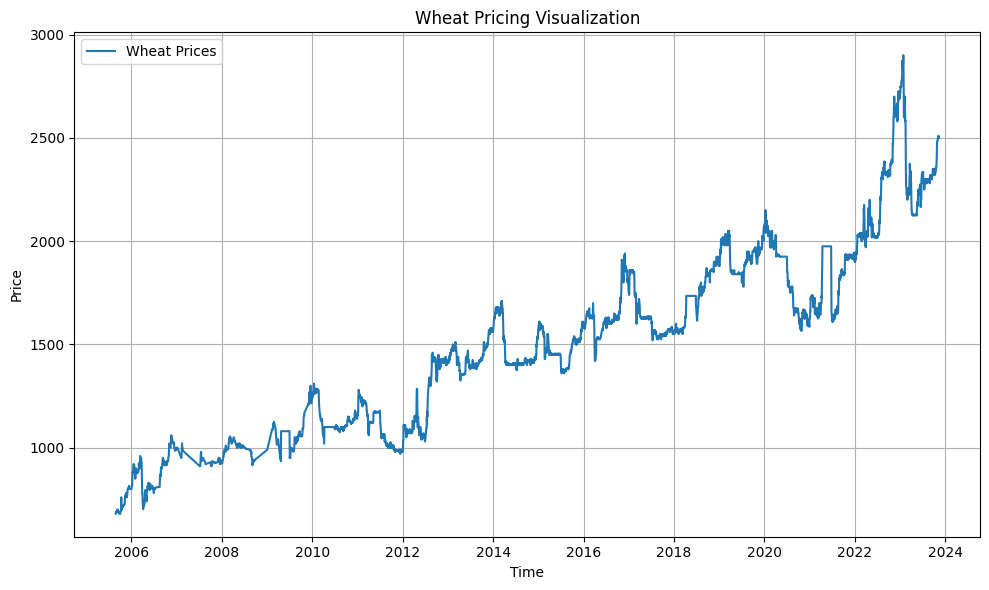

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['modal_price'], linestyle='-', label='Wheat Prices')
plt.title('Wheat Pricing Visualization')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df.to_csv('L_cleaned_modal_pricing_uttar_pradesh.csv', index=False)
